In [615]:
import pandas as pd
import os

def get_dataframe(dataset_path, encoding="utf-8"):
    try:
        # List all files in the dataset directory
        files = os.listdir(dataset_path)

        # Dictionary to store DataFrames
        dataframes = {}

        # Loop through each file
        for file in files:
            file_path = os.path.join(dataset_path, file)

            # Check for .csv or .txt files
            if file.endswith(".csv"):
                data = pd.read_csv(file_path, engine='c', encoding=encoding)
                dataframes[file] = data
            elif file.endswith(".txt"):
                data = pd.read_csv(file_path, delimiter='[|\t]', engine='python', header=None, encoding=encoding)
                dataframes[file] = data
        return dataframes
    except FileNotFoundError as e:
        print(f"Error: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

In [616]:
kmrd_path = "../../kmrd-small"
dataframes = get_dataframe(kmrd_path)
print(f"{dataframes.keys()}")

dict_keys(['countries.csv', 'movies.txt', 'genres.csv', 'rates.csv', 'peoples.txt', 'castings.csv'])


# 결측치 처리

### countries

In [617]:
# countries.csv 데이터프레임 불러오기
countries_df = dataframes['countries.csv']


In [618]:
print(countries_df.head(3))
countries_df.info()


   movie country
0  10001    이탈리아
1  10001     프랑스
2  10002      미국
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1109 entries, 0 to 1108
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movie    1109 non-null   int64 
 1   country  1109 non-null   object
dtypes: int64(1), object(1)
memory usage: 17.5+ KB


In [619]:
countries_df.isna( ).sum( )

movie      0
country    0
dtype: int64

countries에는 결측치 없음

### movies

In [620]:
# movies.txt 데이터프레임 불러오기
movies_df = dataframes['movies.txt'].copy()

print(movies_df.head(3))
movies_df.info()

       0         1                          2     3        4
0  movie     title                  title_eng  year    grade
1  10001    시네마 천국     Cinema Paradiso , 1988  2013   전체 관람가
2  10002  빽 투 더 퓨쳐  Back To The Future , 1985  2015  12세 관람가
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       1000 non-null   object
 1   1       993 non-null    object
 2   2       992 non-null    object
 3   3       610 non-null    object
 4   4       958 non-null    object
dtypes: object(5)
memory usage: 39.2+ KB


In [621]:
# 첫 번째 행 제거 및 열 이름 설정
movies_df.columns = movies_df.iloc[0]  # 첫 번째 행을 열 이름으로 설정
movies_df = movies_df.iloc[1:]  # 첫 번째 행 제거

# 인덱스 재설정
movies_df.reset_index(drop=True, inplace=True)

# 결과 확인
print(movies_df.head(3))

0  movie       title                         title_eng  year    grade
0  10001      시네마 천국            Cinema Paradiso , 1988  2013   전체 관람가
1  10002    빽 투 더 퓨쳐         Back To The Future , 1985  2015  12세 관람가
2  10003  빽 투 더 퓨쳐 2  Back To The Future Part 2 , 1989  2015  12세 관람가


결측치 많이 있음
title, title_eng의 경우 중요한 정보이므로 결측치는 행 제거로 처리
year, grade는 상대적으로 부수적인 정보이고, 결측치 제거 시 너무 많은 행이 삭제될 수 있음.
year는 최빈값으로, grade는 unknown으로 처리

In [622]:
# 1. Title과 Title_eng의 결측치를 처리
# 둘 중 하나만 있는 경우, 없는 값을 다른 값으로 채움
movies_df.loc[movies_df['title'].isnull() & movies_df['title_eng'].notnull(), 'title'] = movies_df['title_eng']
movies_df.loc[movies_df['title_eng'].isnull() & movies_df['title'].notnull(), 'title_eng'] = movies_df['title']

# 둘 다 없는 경우 해당 행 제거
movies_df = movies_df.dropna(subset=['title', 'title_eng'])


# 2. Year 열의 결측치를 최빈값으로 채움
if movies_df['year'].isnull().sum() > 0:  # 결측치가 있는 경우
    most_frequent_year = movies_df['year'].mode()[0]  # 최빈값 계산
    movies_df['year'] = movies_df['year'].fillna(most_frequent_year)

# 3. Grade 열의 결측치를 'Unknown'으로 채움
movies_df['grade'] = movies_df['grade'].fillna('Unknown')

# 4. type 재설정
movies_df['movie'] = movies_df['movie'].astype(int)
movies_df['year'] = movies_df['year'].astype(int)

# 결과 확인
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 992 entries, 0 to 998
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   movie      992 non-null    int64 
 1   title      992 non-null    object
 2   title_eng  992 non-null    object
 3   year       992 non-null    int64 
 4   grade      992 non-null    object
dtypes: int64(2), object(3)
memory usage: 46.5+ KB


In [623]:
movies_df.isna().sum()

0
movie        0
title        0
title_eng    0
year         0
grade        0
dtype: int64

### genres

In [624]:
# genres.csv 데이터프레임 불러오기
genres_df = dataframes['genres.csv']

print(genres_df.head(3))
genres_df.info()

   movie   genre
0  10001     드라마
1  10001  멜로/로맨스
2  10002      SF
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2025 entries, 0 to 2024
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   movie   2025 non-null   int64 
 1   genre   2025 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.8+ KB


In [625]:
genres_df.isna().sum()

movie    0
genre    0
dtype: int64

결측치 없음

### rates

In [626]:
# rates.csv 데이터프레임 불러오기
rates_df = dataframes['rates.csv']

print(rates_df.head(3))
rates_df.info()

   user  movie  rate        time
0     0  10003     7  1494128040
1     0  10004     7  1467529800
2     0  10018     9  1513344120
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140710 entries, 0 to 140709
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   user    140710 non-null  int64
 1   movie   140710 non-null  int64
 2   rate    140710 non-null  int64
 3   time    140710 non-null  int64
dtypes: int64(4)
memory usage: 4.3 MB


In [627]:
# Unix 타임스탬프를 datetime으로 변환
rates_df['time'] = pd.to_datetime(rates_df['time'], unit='s')

# 결과 확인
print(rates_df.head(3))
rates_df.info()

   user  movie  rate                time
0     0  10003     7 2017-05-07 03:34:00
1     0  10004     7 2016-07-03 07:10:00
2     0  10018     9 2017-12-15 13:22:00
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140710 entries, 0 to 140709
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   user    140710 non-null  int64         
 1   movie   140710 non-null  int64         
 2   rate    140710 non-null  int64         
 3   time    140710 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 4.3 MB


In [628]:
rates_df.isna().sum()

user     0
movie    0
rate     0
time     0
dtype: int64

결측치 없음

### peoples

In [629]:
# peoples.txt 데이터프레임 불러오기
peoples_df = dataframes['peoples.txt'].copy()

print(peoples_df.head(3))
peoples_df.info()

        0        1             2
0  people   korean      original
1       5   아담 볼드윈  Adam Baldwin
2       8  애드리안 라인   Adrian Lyne
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7173 entries, 0 to 7172
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       7173 non-null   object
 1   1       7173 non-null   object
 2   2       6306 non-null   object
dtypes: object(3)
memory usage: 168.2+ KB


In [630]:
# 첫 번째 행 제거 및 열 이름 설정
peoples_df.columns = peoples_df.iloc[0]  # 첫 번째 행을 열 이름으로 설정
peoples_df = peoples_df.iloc[1:]  # 첫 번째 행 제거

# 인덱스 재설정
peoples_df.reset_index(drop=True, inplace=True)

# 결과 확인
print(peoples_df.head(3))
peoples_df.info()

0 people   korean      original
0      5   아담 볼드윈  Adam Baldwin
1      8  애드리안 라인   Adrian Lyne
2      9    에이단 퀸   Aidan Quinn
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7172 entries, 0 to 7171
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   people    7172 non-null   object
 1   korean    7172 non-null   object
 2   original  6305 non-null   object
dtypes: object(3)
memory usage: 168.2+ KB


In [631]:
peoples_df['original'] = peoples_df['original'].fillna('Unknown')

# 4. type 재설정
peoples_df['people'] = peoples_df['people'].astype(int)

peoples_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7172 entries, 0 to 7171
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   people    7172 non-null   int64 
 1   korean    7172 non-null   object
 2   original  7172 non-null   object
dtypes: int64(1), object(2)
memory usage: 168.2+ KB


In [632]:
peoples_df.isna().sum()

0
people      0
korean      0
original    0
dtype: int64

### castings

In [633]:
# castings.csv 데이터프레임 불러오기
castings_df = dataframes['castings.csv']

print(castings_df.head(3))
castings_df.info()

   movie  people  order  leading
0  10001    4374      1        1
1  10001     178      2        1
2  10001    3241      3        1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9776 entries, 0 to 9775
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   movie    9776 non-null   int64
 1   people   9776 non-null   int64
 2   order    9776 non-null   int64
 3   leading  9776 non-null   int64
dtypes: int64(4)
memory usage: 305.6 KB


In [634]:
castings_df.isna().sum()

movie      0
people     0
order      0
leading    0
dtype: int64

결측치 없음

# Histogram, Box Plot

### Histogram

In [635]:
import matplotlib.pyplot as plt
import numpy as np

def show_multiple_histograms_with_map(column_map, bins=20):
    """
    Parameters:
        column_map (dict): {라벨: 데이터} 형식의 매핑된 딕셔너리.
        bins (int): 히스토그램의 bin 개수 (기본값: 20).
    """
    labels = list(column_map.keys())  # 라벨 리스트
    columns = list(column_map.values())  # 컬럼 데이터 리스트
    num_columns = len(columns)
    num_rows = (num_columns + 1) // 2  # 한 행에 두 개씩 배치

    # 크기 조정
    fig, axes = plt.subplots(num_rows, 2, figsize=(10, 4 * num_rows))

    # Flatten axes for easier indexing
    axes = axes.flatten()

    # 각 컬럼에 대해 히스토그램 그리기
    for i, (label, column_data) in enumerate(column_map.items()):
        counts, _, _ = axes[i].hist(
            column_data, 
            bins=10,
            alpha=0.6, 
            rwidth=1.0
        )
        
        # y축 간격 설정
        max_count = counts.max()  # 히스토그램 막대의 최대 높이
        if max_count <= 40000:  # y축 최대값이 40,000 이하일 경우
            y_ticks = np.arange(0, max_count, 5000)
        else:  # 40,000 이상인 경우 기본 간격으로 설정
            y_ticks = np.arange(0, max_count, 20000)
        axes[i].set_yticks(y_ticks)
        
        # 그래프 제목 및 레이블 설정
        axes[i].set_title(label, fontsize=14)
        # axes[i].set_ylabel("Frequency", fontsize=12)
        axes[i].grid(True)

    # 남은 subplot 처리 (홀수 개일 경우 오른쪽 subplot 숨기기)
    if num_columns % 2 != 0:
        axes[-1].set_visible(False)

    plt.tight_layout()
    plt.show()


In [636]:
rates_df.head(3)

,user,movie,rate,time
0,0,10003,7,2017-05-07 03:34:00
1,0,10004,7,2016-07-03 07:10:00
2,0,10018,9,2017-12-15 13:22:00


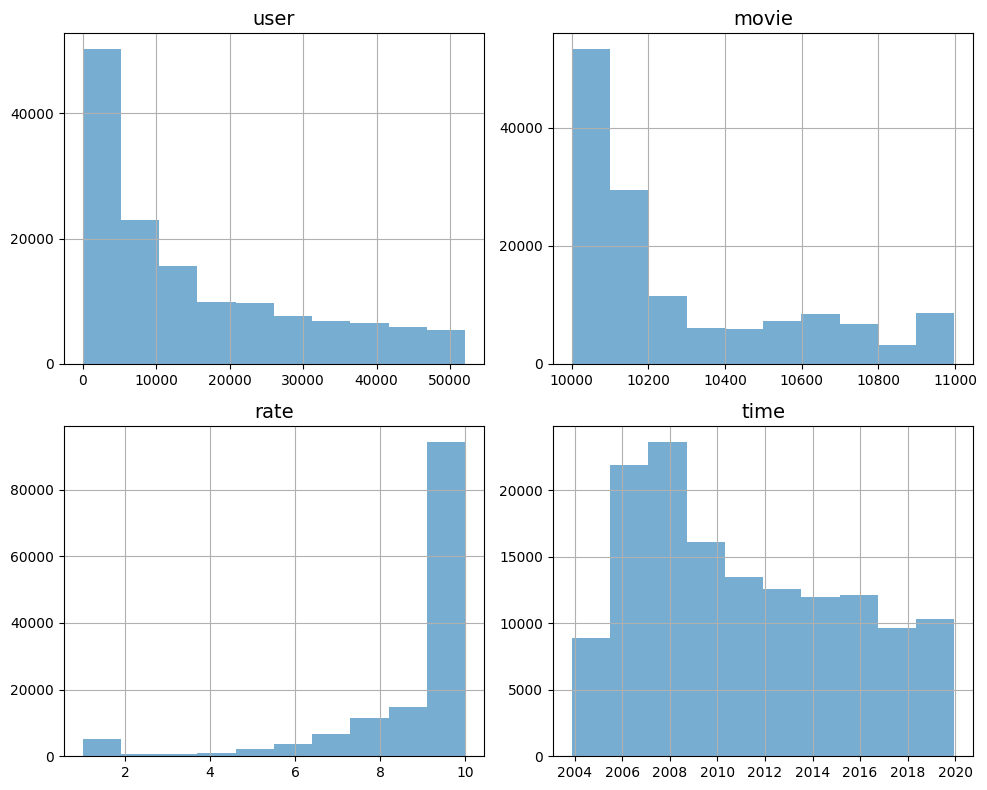

In [637]:
rates_df.head(3)
# describe 데이터를 참고하여 컬럼과 라벨을 딕셔너리로 매핑
column_map = {
    'user': rates_df['user'],
    'movie': rates_df['movie'],
    'rate': rates_df['rate'],
    'time': rates_df['time']
}

# 히스토그램 표시
show_multiple_histograms_with_map(column_map)


### Box Plot

In [651]:
import matplotlib.pyplot as plt

def show_boxplots_and_violinplots_with_map(column_map):
    """
    Parameters:
        column_map (dict): {라벨: 데이터} 형식의 매핑된 딕셔너리.
    """
    labels = list(column_map.keys())  # 라벨 리스트
    columns = list(column_map.values())  # 컬럼 데이터 리스트
    num_columns = len(columns)
    num_rows = (num_columns + 1) // 2  # 각 행에 두 개씩 배치

    # 크기 조정
    fig, axes = plt.subplots(num_rows, 2, figsize=(12, 4 * num_rows))  # 2열: 왼쪽 박스플롯, 오른쪽 바이올린 플롯

    # Flatten axes for easier indexing
    axes = axes.flatten()

    # 각 컬럼에 대해 플롯 그리기
    for i, (label, column_data) in enumerate(column_map.items()):
        # 왼쪽 박스플롯
        axes[2 * i].boxplot(
            column_data,
            patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='blue'),
            medianprops=dict(color='red')
        )
        axes[2 * i].set_title(f"{label} - Boxplot", fontsize=14)
        axes[2 * i].grid(True)

        # 오른쪽 바이올린 플롯
        axes[2 * i + 1].violinplot(
            column_data,
            showmeans=True,
            showmedians=True,
            widths=0.7
        )
        axes[2 * i + 1].set_title(f"{label} - Violin Plot", fontsize=14)
        axes[2 * i + 1].grid(True)

    # 남은 subplot 처리 (홀수 개일 경우 오른쪽 subplot 숨기기)
    for j in range(2 * num_columns, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()


In [652]:
rates_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140710 entries, 0 to 140709
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   user    140710 non-null  int64         
 1   movie   140710 non-null  int64         
 2   rate    140710 non-null  int64         
 3   time    140710 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 4.3 MB


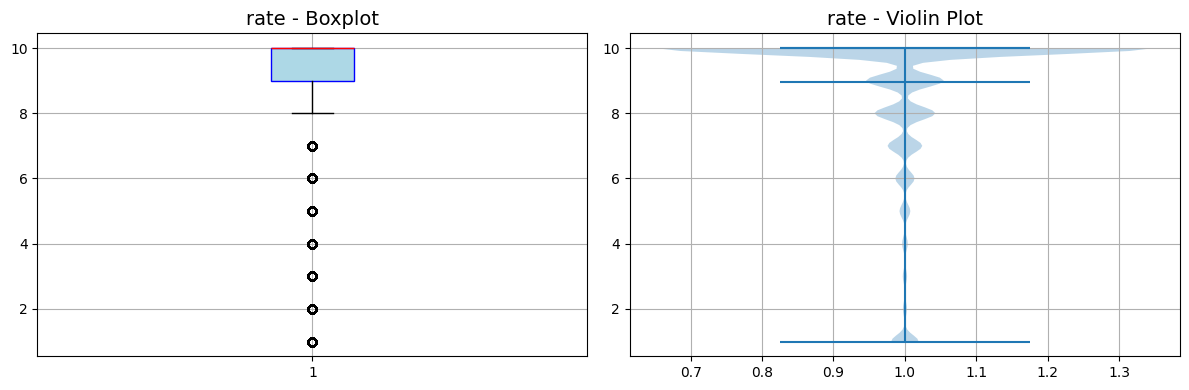

In [653]:
column_map = {
    'rate': rates_df['rate'],
}
show_boxplots_and_violinplots_with_map(column_map)


In [654]:
rates_df['rate'].describe()

count    140710.000000
mean          8.953258
std           2.106047
min           1.000000
25%           9.000000
50%          10.000000
75%          10.000000
max          10.000000
Name: rate, dtype: float64

### 가장 많이 평가된 영화 리스트?

In [667]:
# 1. 각 영화별 평가 횟수 계산
movie_rating_counts = rates_df.groupby('movie')['rate'].count().reset_index()
movie_rating_counts = movie_rating_counts.rename(columns={'rate': 'num_ratings'})

# 2. movies_df와 연결하여 영화 제목 추가
movies_with_ratings = movie_rating_counts.merge(movies_df, on='movie')

# 3. 가장 많이 평가된 영화 (내림차순 정렬)
most_rated_movies = movies_with_ratings.sort_values(by='num_ratings', ascending=False)

print("가장 많이 평가된 영화:")
print(most_rated_movies[['title', 'num_ratings']].head(10))

# 4. 평가 횟수가 1인 영화 필터링
single_rated_movies = movies_with_ratings[movies_with_ratings['num_ratings'] == 1]

# 평가 횟수가 1인 영화 제목 리스트로 변환
single_rated_movies_list = single_rated_movies['title'].tolist()

print("\n평가 횟수가 1인 영화 리스트:")
print(single_rated_movies_list)


가장 많이 평가된 영화:
            title  num_ratings
164  터미네이터 2:오리지널         7265
44      죽은 시인의 사회         7016
83      사운드 오브 뮤직         4391
14        나 홀로 집에         4029
568           가위손         3690
0          시네마 천국         3635
1        빽 투 더 퓨쳐         3004
64             대부         2960
94          아마데우스         2901
90           영웅본색         2214

평가 횟수가 1인 영화 리스트:
['대통령을 만드는 사람들', '핑크 팬더 4 - 핑크 팬더의 역습', '선샤인', '성춘향전', '위대한 지그펠드', '비치 바니즈', '내 친구 제제', '이자벨 에버하트', '천국으로 가는 장의사', '위기의 여자', '원 + 씩스', '한니발', '쥬리아']


In [533]:
# 2. 가장 높은 평균 평점을 받은 영화
highest_rated_movies = rates_df.groupby('movie')['rate'].mean().reset_index()
highest_rated_movies = highest_rated_movies.rename(columns={'rate': 'avg_rating'})

# movies_df와 연결하여 영화 제목 추가
highest_rated_movies_with_titles = highest_rated_movies.merge(movies_df, on='movie')

# 내림차순 정렬
highest_rated_movies_with_titles = highest_rated_movies_with_titles.sort_values(by='avg_rating', ascending=False)

# 상위 10개 출력
print("가장 높은 평균 평점을 받은 영화:")
print(highest_rated_movies_with_titles[['title', 'avg_rating']].head(10))


가장 높은 평균 평점을 받은 영화:
            title  avg_rating
586           쥬리아      10.000
548        피부 깊숙이      10.000
504       내 친구 제제      10.000
149  대통령을 만드는 사람들      10.000
358          성춘향전      10.000
362            비황      10.000
569        위기의 여자      10.000
273            여로      10.000
77          마이 웨이       9.875
351     저 하늘에 태양이       9.800


# Line plot
시간에 따른 평점의 변화나 패턴을 라인 플롯으로 확인하라. (Line chart)

In [534]:
print(rates_df.head(3))

rates_df.info()

   user  movie  rate                time
0     0  10003     7 2017-05-07 03:34:00
1     0  10004     7 2016-07-03 07:10:00
2     0  10018     9 2017-12-15 13:22:00
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140710 entries, 0 to 140709
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   user    140710 non-null  int64         
 1   movie   140710 non-null  int64         
 2   rate    140710 non-null  int64         
 3   time    140710 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 4.3 MB


In [535]:
print(most_rated_movies_with_titles[['movie', 'num_ratings', 'title']].head(10))

     movie  num_ratings         title
164  10200         7265  터미네이터 2:오리지널
44   10048         7016     죽은 시인의 사회
83   10102         4391     사운드 오브 뮤직
14   10016         4029       나 홀로 집에
568  10936         3690           가위손
0    10001         3635        시네마 천국
1    10002         3004      빽 투 더 퓨쳐
64   10071         2960            대부
94   10114         2901         아마데우스
90   10110         2214          영웅본색


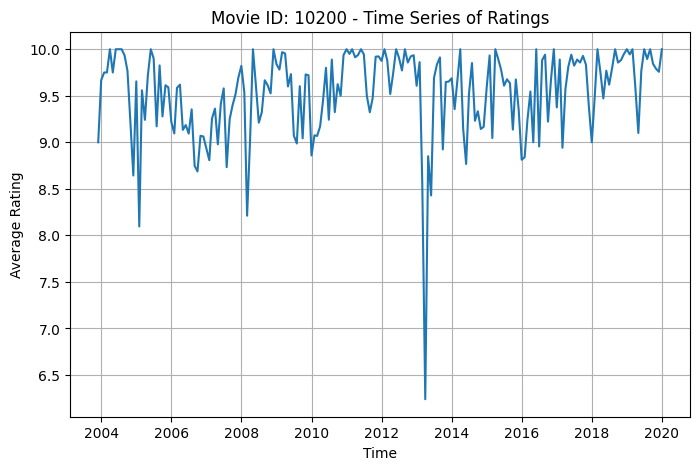

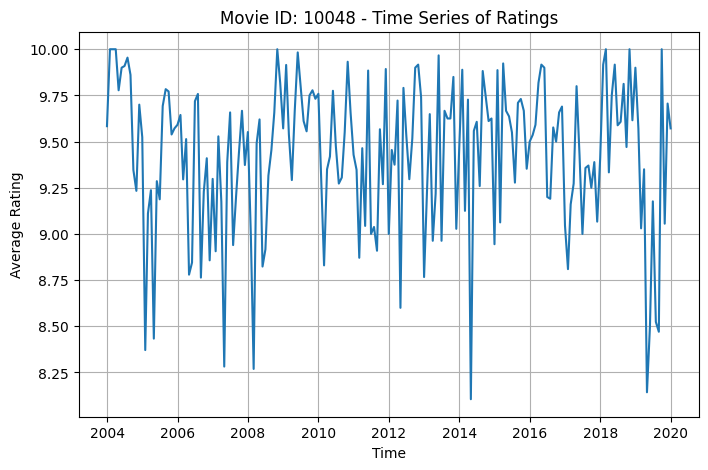

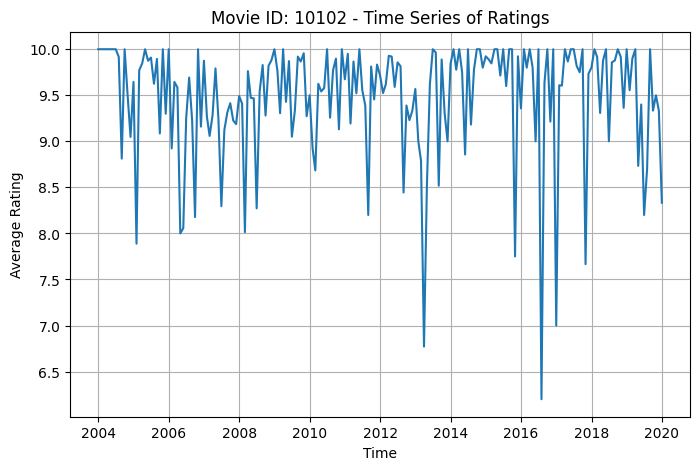

In [536]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_movie_rate_over_time(df, movie_id):
    """
    특정 movie_id의 시간 흐름별 평균 평점을 선 그래프로 그리는 함수
    """
    # movie_id로 필터링
    temp = df[df['movie'] == movie_id].copy()
    
    # 시간 컬럼을 인덱스로 설정
    temp.set_index('time', inplace=True)
    
    # 1개월 단위로 리샘플링하여 평균 평점 계산 (ME: Month End)
    resampled = temp['rate'].resample('ME').mean()
    
    # 그래프 그리기
    plt.figure(figsize=(8, 5))
    plt.plot(resampled.index, resampled.values)
    plt.title(f"Movie ID: {movie_id} - Time Series of Ratings")
    plt.xlabel("Time")
    plt.ylabel("Average Rating")
    plt.grid(True)
    plt.show()


# 예시) most_rated_movies_with_titles 에서 상위 3개 영화만 가져와 반복
top_3_movies = most_rated_movies_with_titles.head(3)

for idx, row in top_3_movies.iterrows():
    movie_id = row['movie']  # 실제 컬럼명에 맞춰서 사용
    plot_movie_rate_over_time(rates_df, movie_id)


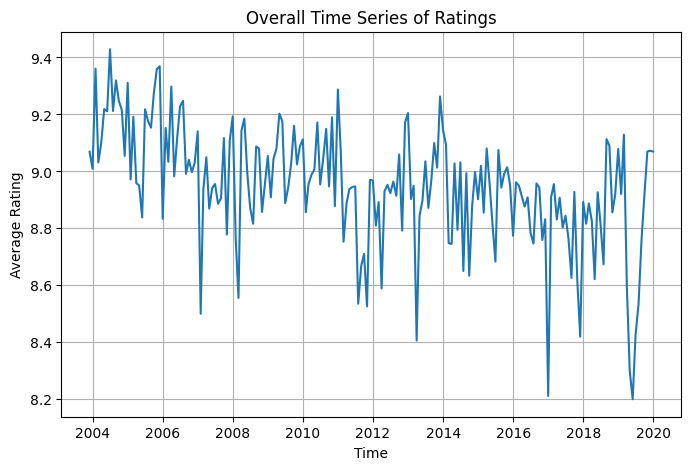

In [524]:
def plot_overall_rate_over_time(df):
    """
    전체 데이터셋의 시간 흐름별 평균 평점을 선 그래프로 그리는 함수
    """
    # 시간 컬럼을 인덱스로 설정
    temp = df.copy()
    temp.set_index('time', inplace=True)
    
    # 1개월 단위로 리샘플링하여 평균 평점 계산 (ME: Month End)
    resampled = temp['rate'].resample('ME').mean()
    
    # 그래프 그리기
    plt.figure(figsize=(8, 5))
    plt.plot(resampled.index, resampled.values)
    plt.title("Overall Time Series of Ratings")
    plt.xlabel("Time")
    plt.ylabel("Average Rating")
    plt.grid(True)
    plt.show()


# 전체 데이터셋에 대해 시간 흐름별 rate 시각화
plot_overall_rate_over_time(rates_df)
